## Deeplab V3 model for semantic segmentation with pre-trained Resnet50 weights on ImageNet.

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50
import numpy as np # linear algebra
from matplotlib import pyplot as plt
import albumentations as A
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from pathlib import Path

import importlib
import utils as my_utils
importlib.reload(my_utils)

# my own custom class to generate augmented data
from data_generator import DataGenerator
# utility functions implemented in a separate file for reusability
from utils import dice_coef, f1score, sensitivity, specifity, make_pair, loadAndProcessImages, get_image_with_mask_imposed, make_prediction

## Loading data and creating sets for Train, Validation and Test
After loading training data I am using train_test_split to split data into training and validation sets

In [2]:
dataset_path = Path("./A3_Dataset/dataset1/")
list(dataset_path.iterdir())

[PosixPath('A3_Dataset/dataset1/.DS_Store'),
 PosixPath('A3_Dataset/dataset1/annotations_prepped_train'),
 PosixPath('A3_Dataset/dataset1/images_prepped_train'),
 PosixPath('A3_Dataset/dataset1/annotations_prepped_test'),
 PosixPath('A3_Dataset/dataset1/images_prepped_test')]

In [3]:
X = list((dataset_path / "images_prepped_train").glob("*.png"))
y = list((dataset_path / "annotations_prepped_train").glob("*.png"))

sorted(X), sorted(y);

# convert training data into training and validation sets

train_imgs, val_imgs, train_labels, val_labels = train_test_split(X, y, test_size=0.20, random_state=42)

test_imgs = list((dataset_path / "images_prepped_test").glob("*.png"))
test_labels = list((dataset_path / "annotations_prepped_test").glob("*.png"))

sorted(test_imgs), sorted(test_labels);

### Pairing each Image with it's mask. Train Pair, Validation Pair and Test Pair are arrays of tuples

In [4]:
# creating tuples of image and mask
train_pair = make_pair(train_imgs, train_labels)
val_pair = make_pair(val_imgs, val_labels)
test_pair = make_pair(test_imgs, test_labels)

### COLORS: randomly generated 12 colors for class boundary.
### img_size: Tuple specifiying the dimension our network expects of the input image. Original images has a ratio 3:4 but the size is not divisible by 2 and cause issue for decoder. So I chose 192x256 as numbers divisible by 2 many times and also they maintain the 3:4 ratio.

In [5]:
COLORS = np.random.randint(0, 255, size=(12, 3),dtype="uint8")
img_size = (192, 256)

### Helper function that will plot passed images with their corresponding titles, 3 in a row.

In [6]:
def plot_images(images, titles):
    for i in range(len(images)):
        idx = i % 3
        if idx == 0:
            plt.figure(figsize=(25,25))
        plt.subplot(1, 3, idx+1)
        plt.imshow(images[i])
        plt.axis('off')
        plt.title(titles[i])

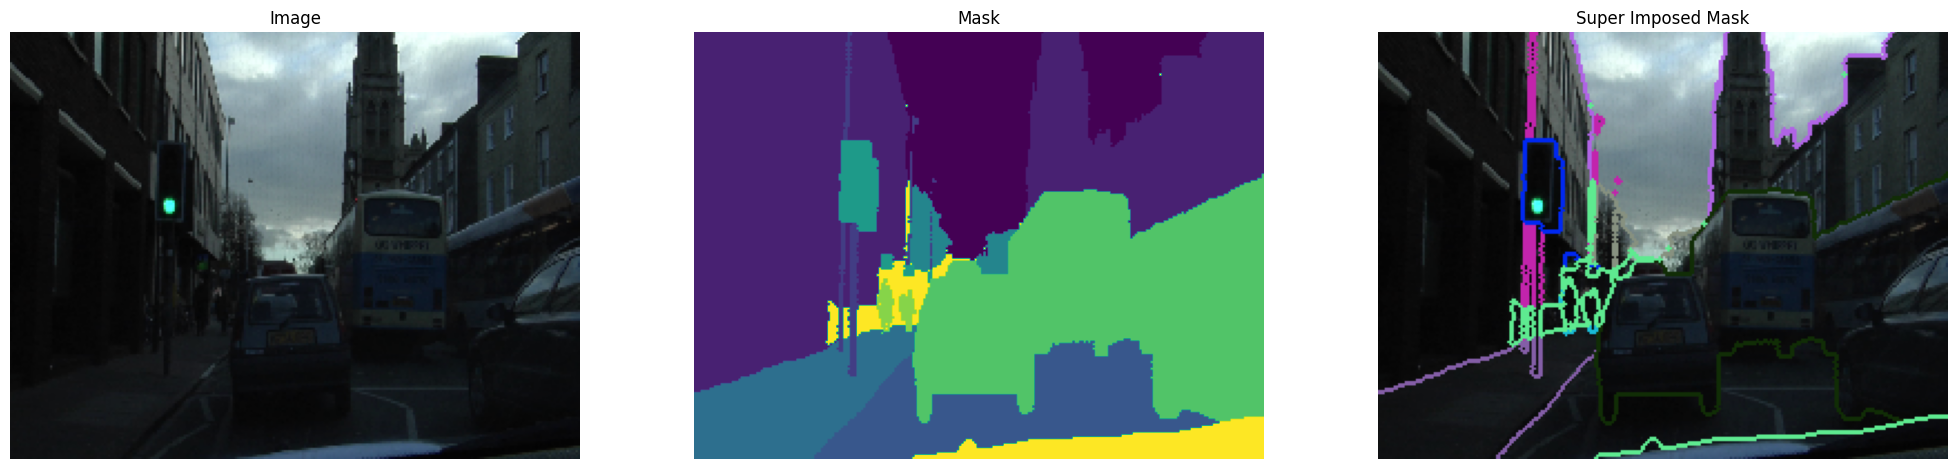

In [7]:
## Plotting a random pair with it's mask imposed

img, mask = loadAndProcessImages(train_pair, img_size)
super_imposed_image = get_image_with_mask_imposed(img, mask[:, :, 0], 12, COLORS)
plot_images([img/255, mask, super_imposed_image/255], ['Image', 'Mask', 'Super Imposed Mask'])

### Transformations to be used for data augmentation.

In [8]:
transformer = A.Compose([
    A.RandomCrop(width=256, height=256, p=0.5),
    A.OneOf([
        A.HorizontalFlip(p=0.6),
        A.VerticalFlip(p=0.4)
    ], p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Rotate(limit=35, p=1.0),
    A.Resize(height=img_size[0], width=img_size[1]),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0,
    ),
])

validation_normaliser = A.Compose([
    A.Resize(height=img_size[0], width=img_size[1]),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0,
    ),
])

### Instances of DataGenerator class, implemented myself.
Data generator class takes list of tuples, transformer function if you want to apply, batch size and dimensions. Data generator will always return a data instance after applying transformation so it is highly possible that if you ask for same data again, it will come back with a different augmentation. You can see this in action below, I am calling same image instance 3 times, but it is appearing with a slightly different augmentation.

In [9]:
train_generator = DataGenerator(train_pair, transformer, batch_size=4, dim=(img_size[0],img_size[1],3), shuffle=True)
train_steps = train_generator.__len__()
train_steps

73

In [10]:
test_generator = DataGenerator(test_pair, transformer, batch_size=4, dim=(img_size[0],img_size[1],3), shuffle=True)
test_steps = test_generator.__len__()
test_steps

25

In [11]:
val_generator = DataGenerator(val_pair, transformer, batch_size=4, dim=(img_size[0],img_size[1],3) ,shuffle=True)
val_steps = val_generator.__len__()
val_steps

18

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(192, 256, 3) (192, 256)
(192, 256, 3) (192, 256)
(192, 256, 3) (192, 256)


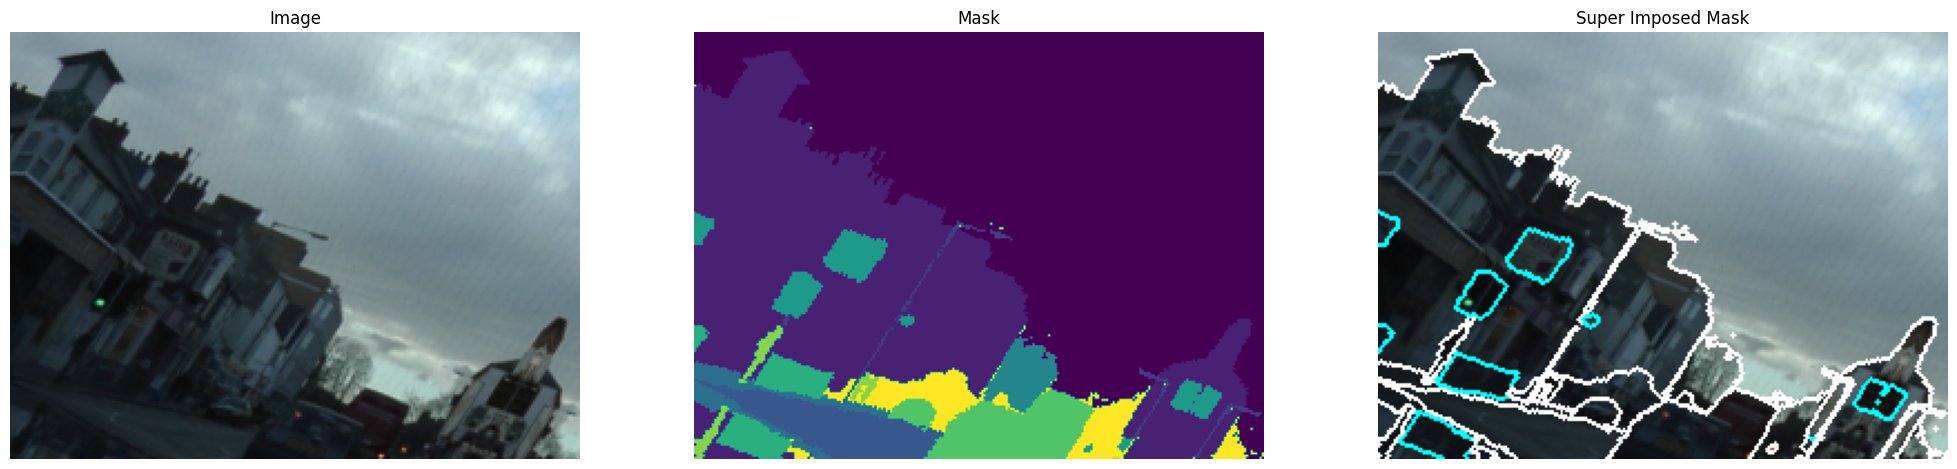

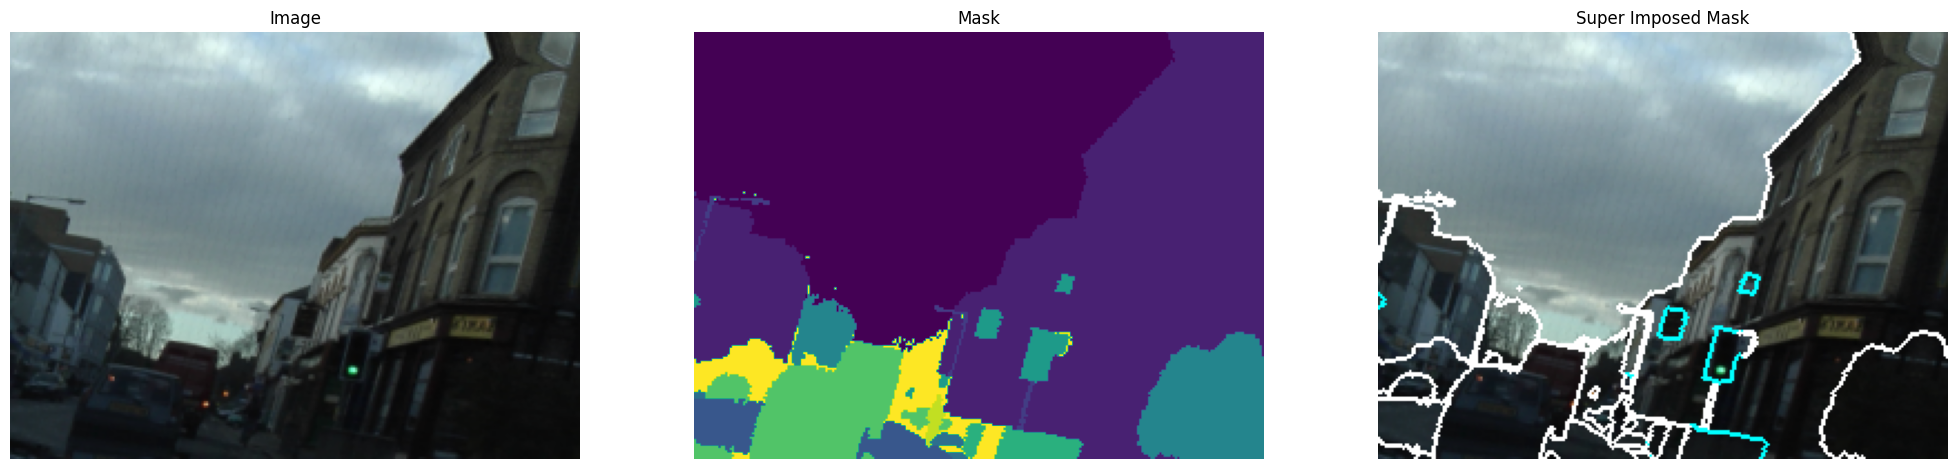

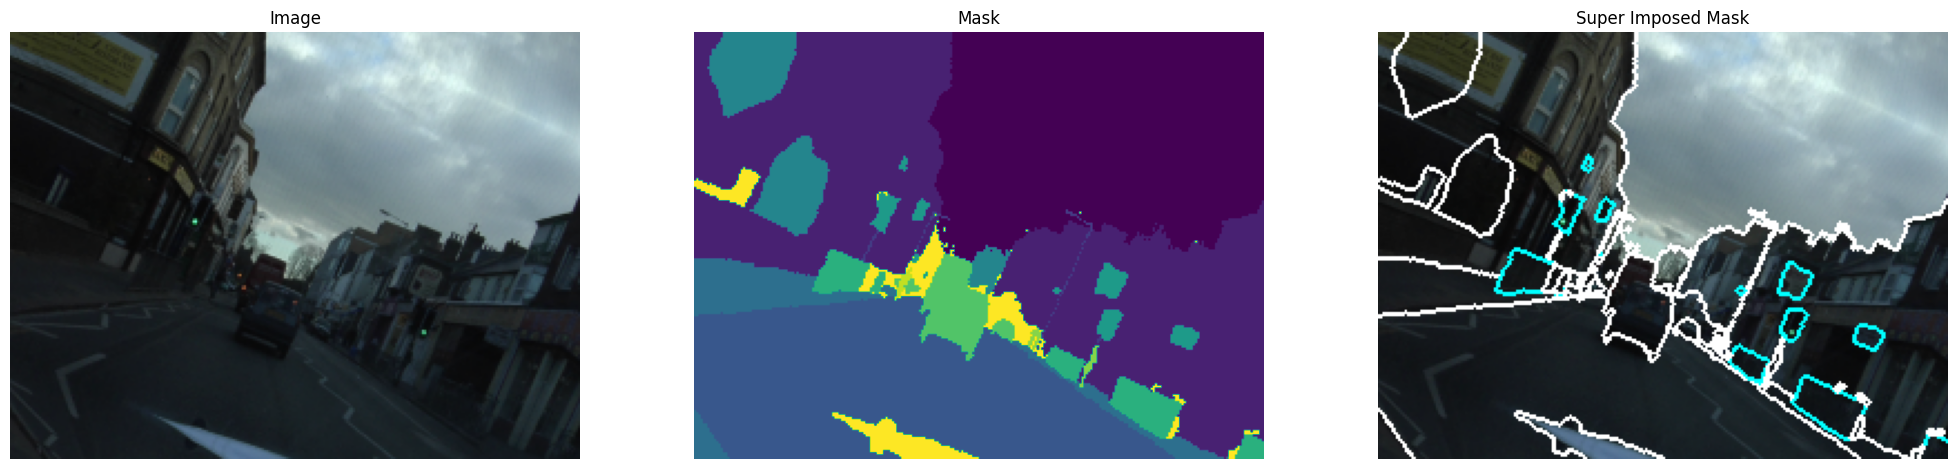

In [12]:
for i in range(3):
    img_batch, mask_batch = train_generator[10]
    img = img_batch[0]
    mask = mask_batch[0]
    mask = np.argmax(mask,axis=2)
    print(img.shape, mask.shape)
    super_imposed_image = get_image_with_mask_imposed(img, mask, 12, COLORS)
    plot_images([img, mask, super_imposed_image], ['Image', 'Mask', 'Super Imposed Mask'])

### Deeplab v3 implementation
I am loading the resnet50 with Imagenet weights, then implemented and applied the ASPP block and upsampled the image by implementing decoder on front of Resnet

In [13]:
def ASPP(inputs):
    shape = inputs.shape
    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)

    y_6 = Conv2D(filters=256, kernel_size=3, dilation_rate=6, padding='same', use_bias=False)(inputs)
    y_6 = BatchNormalization()(y_6)
    y_6 = Activation('relu')(y_6)

    y_12 = Conv2D(filters=256, kernel_size=3, dilation_rate=12, padding='same', use_bias=False)(inputs)
    y_12 = BatchNormalization()(y_12)
    y_12 = Activation('relu')(y_12)

    y_18 = Conv2D(filters=256, kernel_size=3, dilation_rate=18, padding='same', use_bias=False)(inputs)
    y_18 = BatchNormalization()(y_18)
    y_18 = Activation('relu')(y_18)

    y = Concatenate()([y_pool, y_1, y_6, y_12, y_18])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

def DeepLabV3Plus(shape):
    inputs = Input(shape)
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs, classes=12)
    
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])
    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    x = Conv2D(12, (1, 1), name='output_layer')(x)
    x = Activation('softmax')(x)

    model = Model(inputs=inputs, outputs=x)
    return model

In [14]:
input_shape = (img_size[0], img_size[1], 3)
model = DeepLabV3Plus(input_shape)
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 192, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 198, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 96, 128, 64)  9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (Ba

### Compiled the model and fit it on the training data and validation data passed for validation. ReduceLROnPlateau is used and it helps in case our learning is stuck, it reduces the learning rate. Helps in training. Also, model weights are saved and only best weights are kept.

In [15]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', dice_coef, f1score, specifity, sensitivity])

In [16]:
mc = ModelCheckpoint(mode='max', filepath='top-weights.h5', monitor='val_accuracy',save_best_only='True', save_weights_only='True', verbose=1)
rl = ReduceLROnPlateau(monitor='val_accuracy', factor=0.1, patience=5, verbose=1, mode="max", min_lr=0.00001)

In [17]:
results = model.fit(train_generator , steps_per_epoch=train_steps, epochs=50,
                              validation_data=val_generator, validation_steps=val_steps, callbacks=[mc,rl])

Epoch 1/50
73/73 [==============================] - ETA: 0s - loss: 0.9855 - accuracy: 0.7146 - dice_coef: 0.6086 - f1score: 0.6942 - specifity: 0.9644 - sensitivity: 0.6086
Epoch 1: val_accuracy improved from -inf to 0.29470, saving model to top-weights.h5
73/73 [==============================] - 47s 528ms/step - loss: 0.9855 - accuracy: 0.7146 - dice_coef: 0.6086 - f1score: 0.6942 - specifity: 0.9644 - sensitivity: 0.6086 - val_loss: 13.4508 - val_accuracy: 0.2947 - val_dice_coef: 0.2943 - val_f1score: 0.2947 - val_specifity: 0.9358 - val_sensitivity: 0.2942 - lr: 0.0010
Epoch 2/50
73/73 [==============================] - ETA: 0s - loss: 0.7520 - accuracy: 0.7705 - dice_coef: 0.6709 - f1score: 0.7619 - specifity: 0.9701 - sensitivity: 0.6709
Epoch 2: val_accuracy improved from 0.29470 to 0.36832, saving model to top-weights.h5
73/73 [==============================] - 38s 513ms/step - loss: 0.7520 - accuracy: 0.7705 - dice_coef: 0.6709 - f1score: 0.7619 - specifity: 0.9701 - sensitivi

In [18]:
results.history

{'loss': [0.9854537844657898,
  0.751969039440155,
  0.7032032012939453,
  0.6252245903015137,
  0.6021531224250793,
  0.5796629190444946,
  0.5890225768089294,
  0.4852869212627411,
  0.4468333125114441,
  0.4510548710823059,
  0.43664848804473877,
  0.42502838373184204,
  0.41175955533981323,
  0.4066444933414459,
  0.4070107638835907,
  0.39862143993377686,
  0.38972675800323486,
  0.3923625946044922,
  0.38618209958076477,
  0.37928473949432373,
  0.3857899010181427,
  0.36851736903190613,
  0.36315038800239563,
  0.36460375785827637,
  0.34541669487953186,
  0.3603834807872772,
  0.3548218309879303,
  0.3441941738128662,
  0.3366464376449585,
  0.34775763750076294,
  0.3310536742210388,
  0.3234139084815979,
  0.3267729878425598,
  0.32086846232414246,
  0.3332340121269226,
  0.3307158946990967,
  0.32707133889198303,
  0.3140098452568054,
  0.3276379704475403,
  0.3183223605155945,
  0.3322731554508209,
  0.31208714842796326,
  0.3307245969772339,
  0.31805872917175293,
  0.31320

### Plots for Quantitative performance
1. Validation and Training loss: Both losses decrease over the time.
2. Validation and Training Accuracy: Improved over time as expected, Increased to the point of 0.82 in 50 epochs.
3. Validation and Training Dice Coeff: Increased over time.
4. Validation and Training F1 Score: Increased over time.

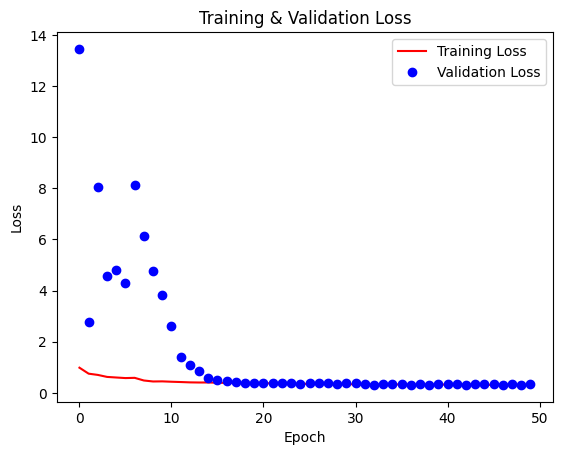

In [19]:
plt.plot(range(50), results.history['loss'], 'r', label='Training Loss')
plt.plot(range(50), results.history['val_loss'], 'bo', label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

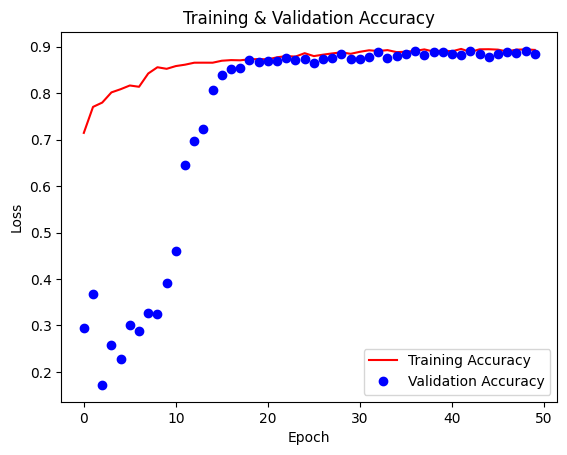

In [20]:
plt.plot(range(50), results.history['accuracy'], 'r', label='Training Accuracy')
plt.plot(range(50), results.history['val_accuracy'], 'bo', label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

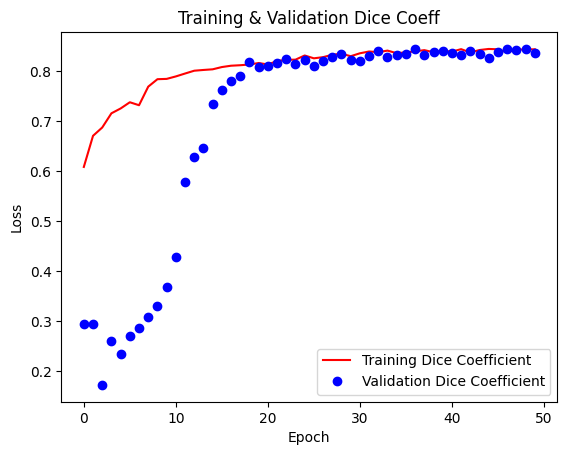

In [21]:
plt.plot(range(50), results.history['dice_coef'], 'r', label='Training Dice Coefficient')
plt.plot(range(50), results.history['val_dice_coef'], 'bo', label='Validation Dice Coefficient')
plt.title('Training & Validation Dice Coeff')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

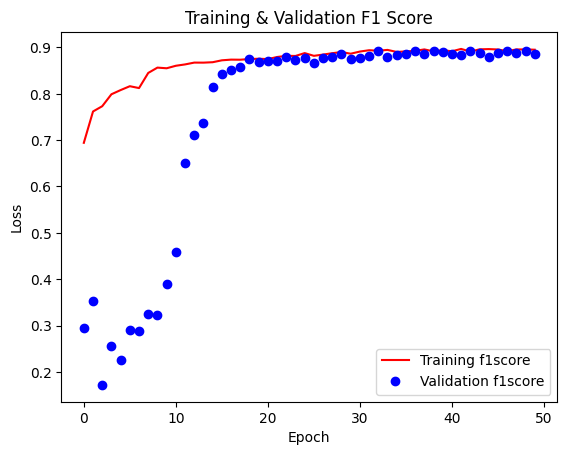

In [22]:
plt.plot(range(50), results.history['f1score'], 'r', label='Training f1score')
plt.plot(range(50), results.history['val_f1score'], 'bo', label='Validation f1score')
plt.title('Training & Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

### Accuracy on Test set

In [23]:
print("Evaluate on test data")
eval_results = model.evaluate(test_generator)
print("test loss, test acc:", eval_results)

Evaluate on test data
25/25 [==============================] - 2s 70ms/step - loss: 0.3749 - accuracy: 0.8777 - dice_coef: 0.8252 - f1score: 0.8783 - specifity: 0.9841 - sensitivity: 0.8252
test loss, test acc: [0.3749156594276428, 0.8776731491088867, 0.8251886367797852, 0.8782592415809631, 0.9841080904006958, 0.8251881003379822]


## Qualitative results

(PosixPath('A3_Dataset/dataset1/images_prepped_test/0016E5_08137.png'), PosixPath('A3_Dataset/dataset1/annotations_prepped_test/0016E5_08137.png'))


/Users/hamzaarshad/miniforge3/envs/assign/lib/python3.9/site-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 2s 2s/step
(PosixPath('A3_Dataset/dataset1/images_prepped_test/0016E5_08043.png'), PosixPath('A3_Dataset/dataset1/annotations_prepped_test/0016E5_08043.png'))
1/1 [==============================] - 0s 48ms/step
(PosixPath('A3_Dataset/dataset1/images_prepped_test/0016E5_08095.png'), PosixPath('A3_Dataset/dataset1/annotations_prepped_test/0016E5_08095.png'))
1/1 [==============================] - 0s 44ms/step
(PosixPath('A3_Dataset/dataset1/images_prepped_test/0016E5_07991.png'), PosixPath('A3_Dataset/dataset1/annotations_prepped_test/0016E5_07991.png'))
1/1 [==============================] - 0s 51ms/step
(PosixPath('A3_Dataset/dataset1/images_prepped_test/0016E5_07993.png'), PosixPath('A3_Dataset/dataset1/annotations_prepped_test/0016E5_07993.png'))
1/1 [==============================] - 0s 45ms/step


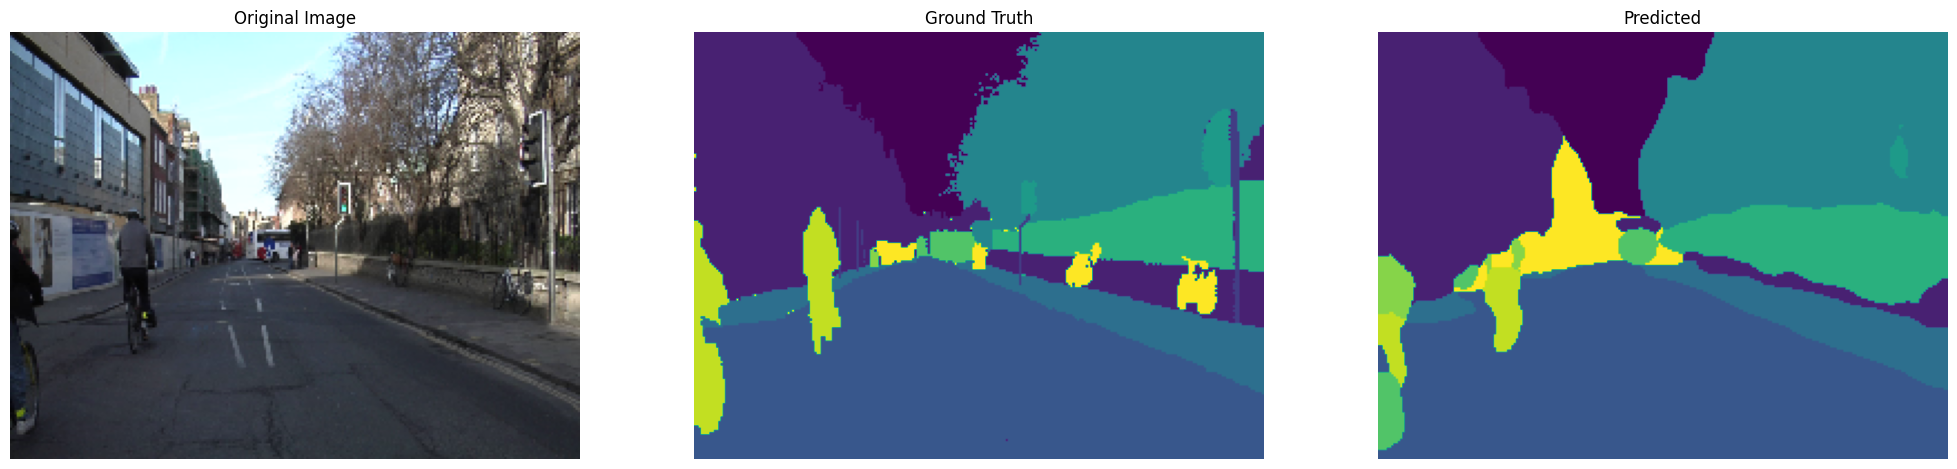

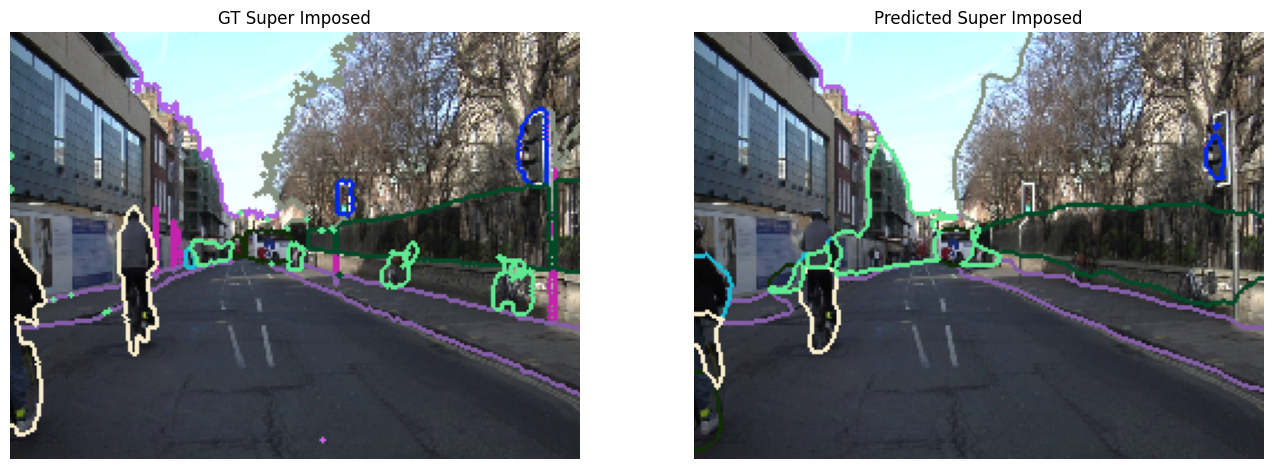

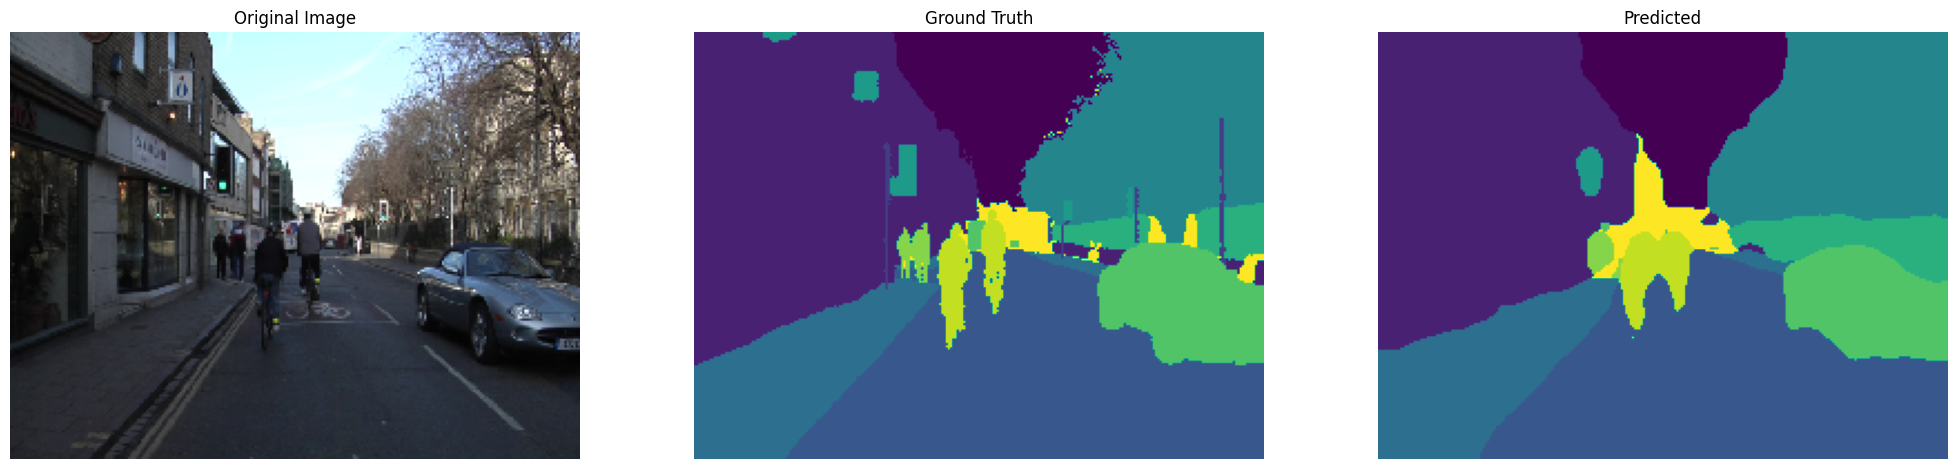

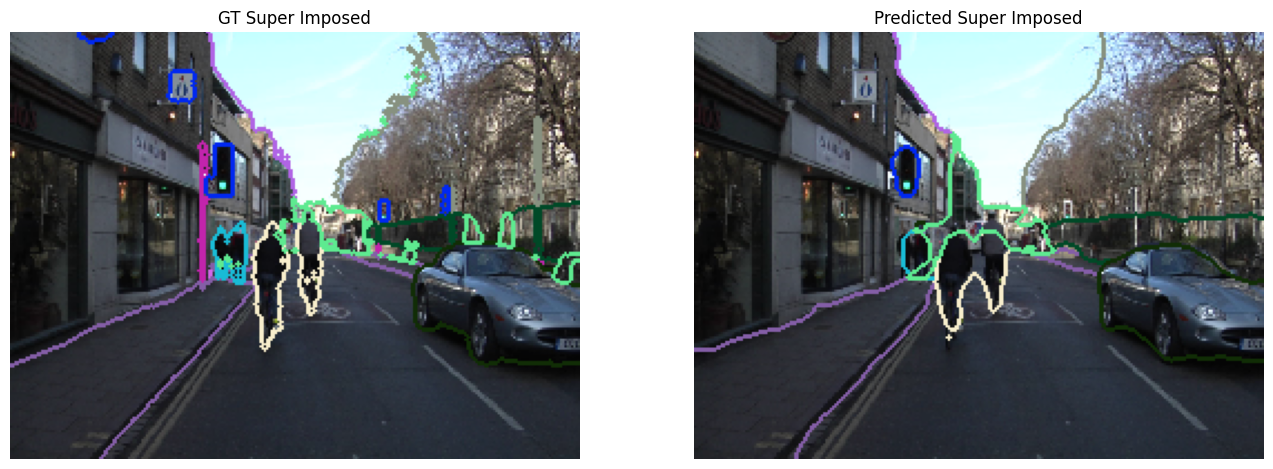

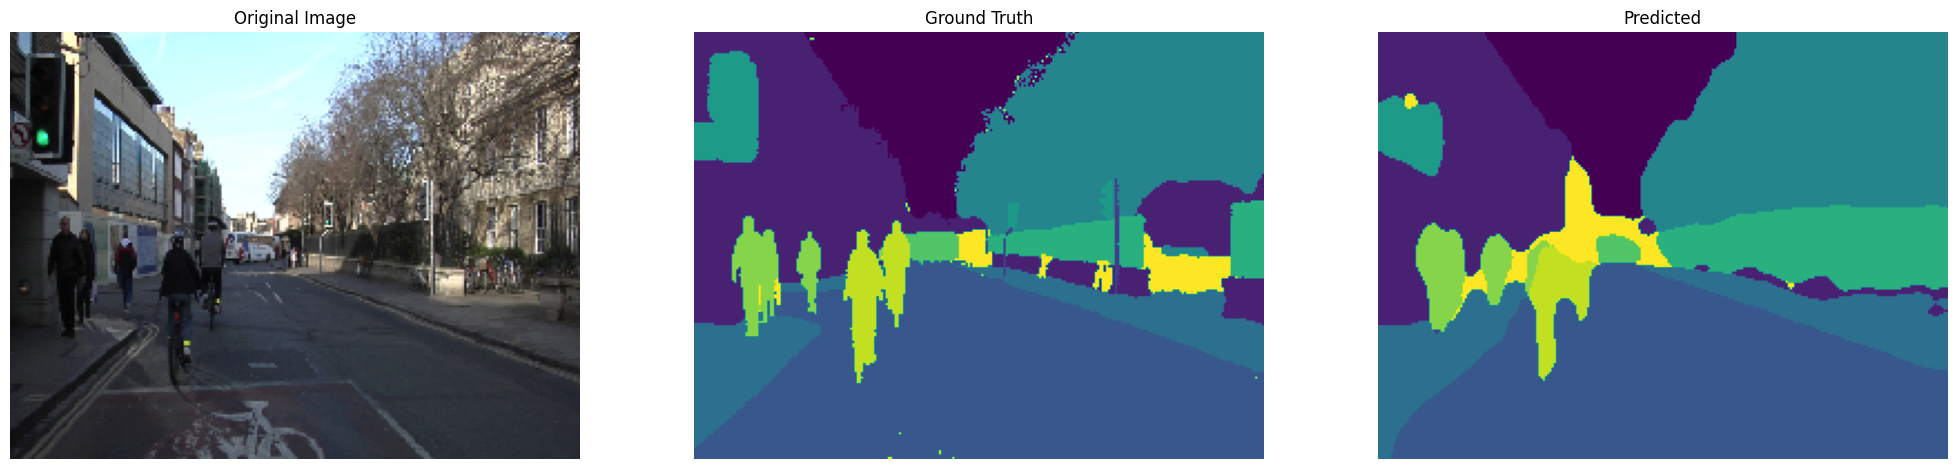

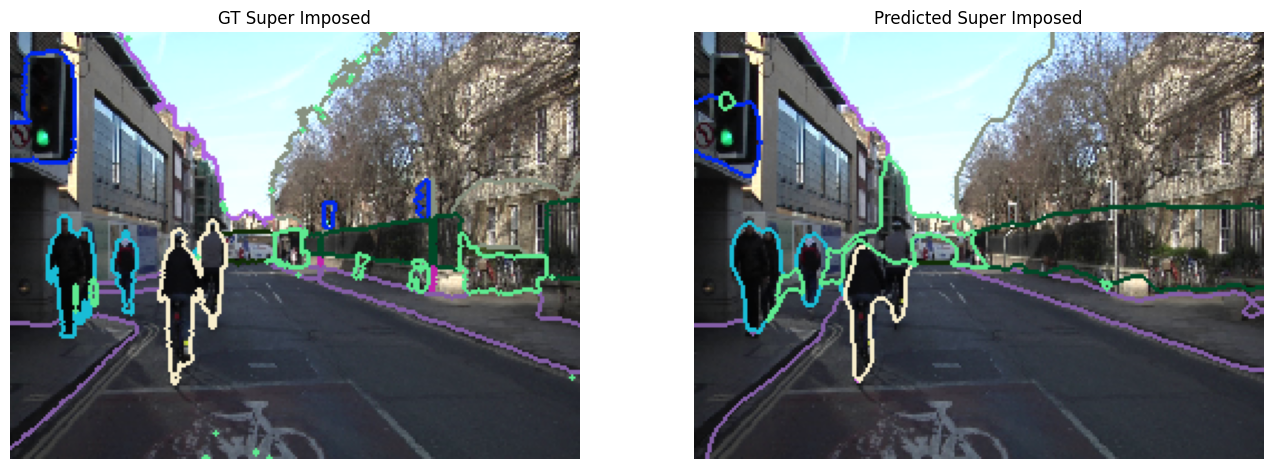

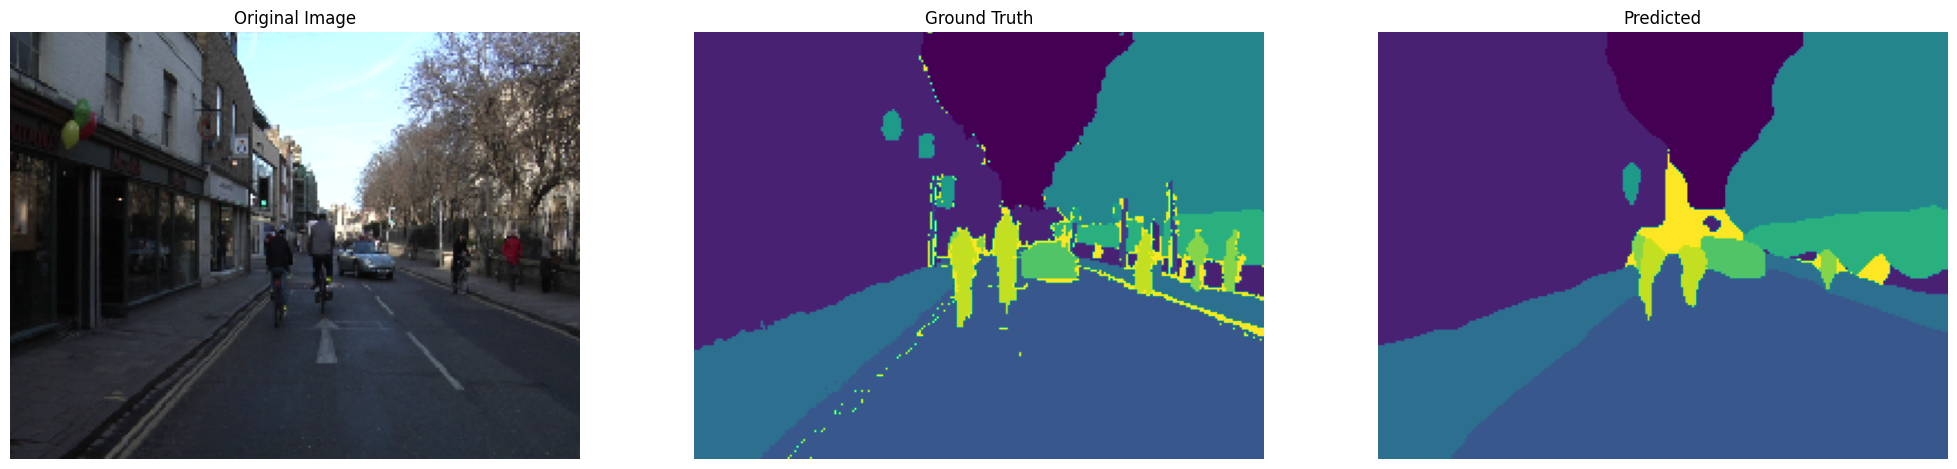

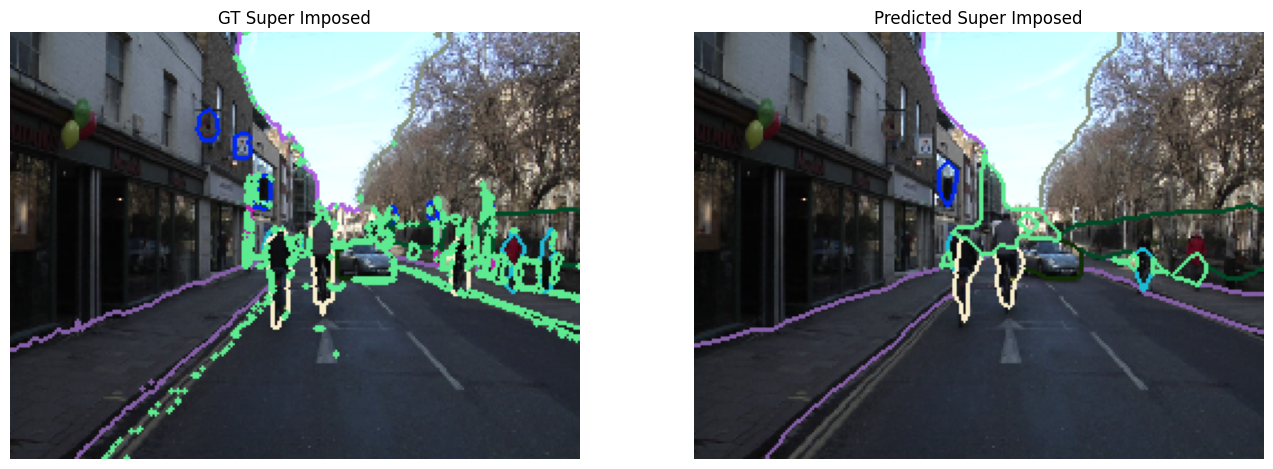

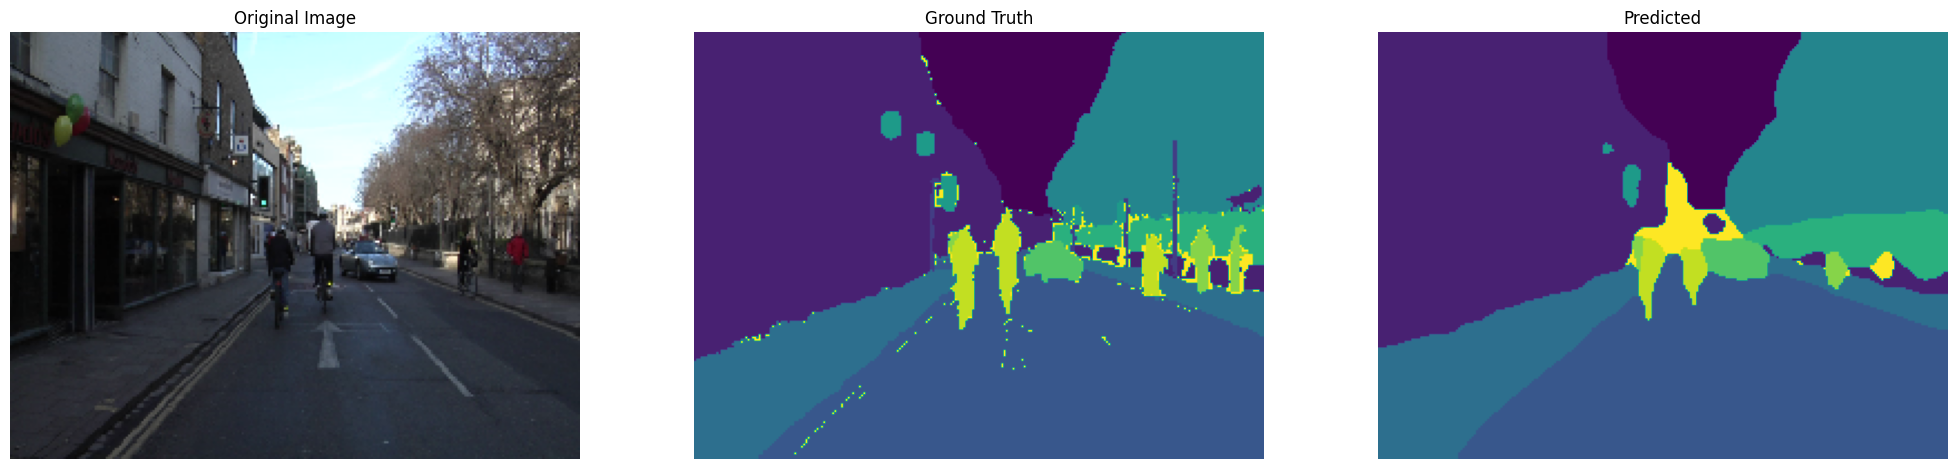

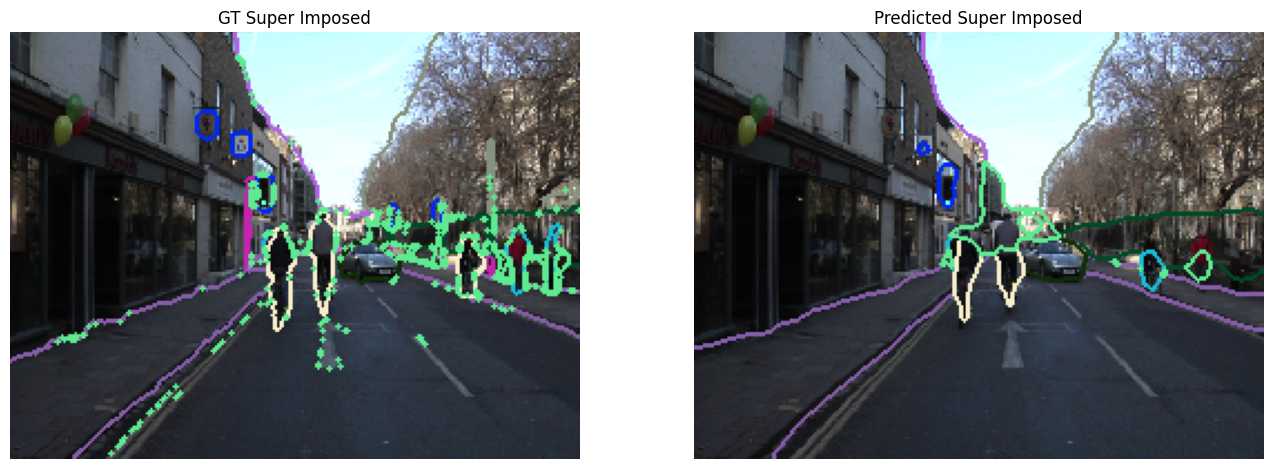

In [24]:
for i in range(5):
    img_mask = test_pair[i*2]
    print(img_mask)
    img= img_to_array(load_img(img_mask[0] , target_size= img_size))
    gt_img = img_to_array(load_img(img_mask[1] , target_size= img_size, grayscale=True))
    pred_label = make_prediction(model, img_mask[0], (img_size[0],img_size[1],3))
    super_imposed_gt = get_image_with_mask_imposed(img, gt_img[:, :, 0], 12, COLORS)
    super_imposed_pred = get_image_with_mask_imposed(img, pred_label, 12, COLORS)
    plot_images([img/255, gt_img, pred_label, super_imposed_gt/255, super_imposed_pred/255], ['Original Image', 'Ground Truth', 'Predicted', 'GT Super Imposed', 'Predicted Super Imposed'])